In [1]:
import os
from glob import glob
import re

import numpy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [6]:
images_dir = Path('../data/images/dim-meteorite-full-res')

first_image = images_dir / "179.png"
second_image = images_dir / "180.png"

Text(0.5, 1.0, 'Frame Difference')

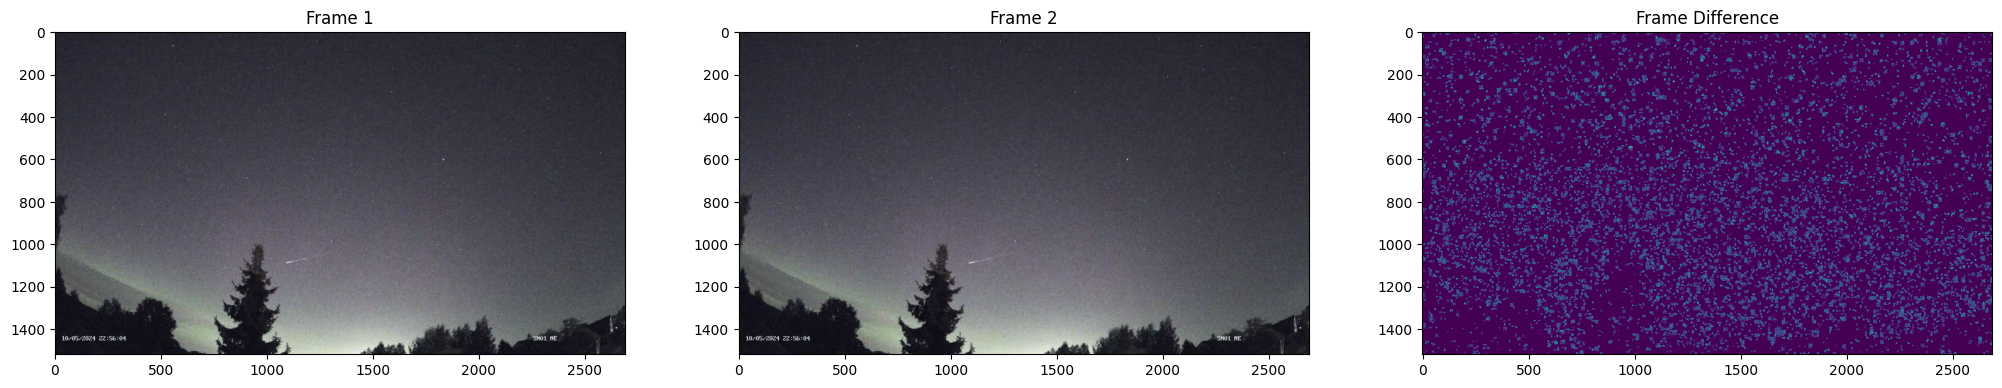

In [7]:
idx = 56

img1_rgb = cv2.cvtColor(cv2.imread(str(first_image.absolute())), cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(cv2.imread(str(second_image.absolute())), cv2.COLOR_BGR2RGB)

# convert to grayscale
img1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)

# compute grayscale image difference
grayscale_diff = cv2.subtract(img2, img1)

fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(grayscale_diff*50) # scale the frame difference to show the noise
ax[2].set_title('Frame Difference')

In [8]:
def get_mask(frame1, frame2, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            kernel - (NxN) array for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    frame_diff = cv2.subtract(frame2, frame1)

    # blur the frame difference
    frame_diff = cv2.medianBlur(frame_diff, 3)
    
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV, 11, 3)

    mask = cv2.medianBlur(mask, 3)

    # morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

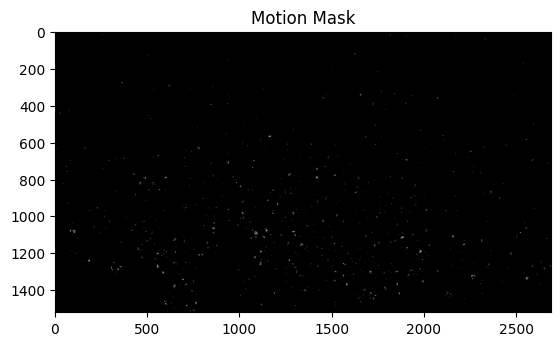

In [9]:
kernel = np.array((9,9), dtype=np.uint8)
mask = get_mask(img1, img2, kernel)

plt.imshow(mask, cmap='gray')
plt.title("Motion Mask");

In [10]:
def get_contour_detections(mask, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the mask. 
        Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

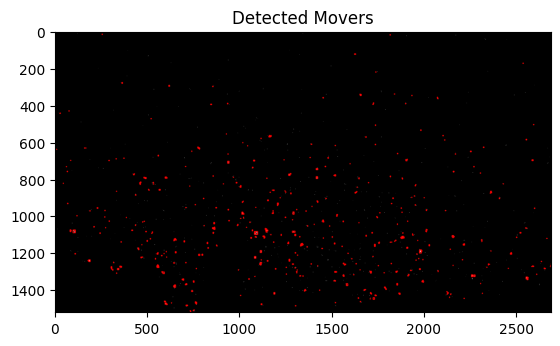

In [11]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections(mask, thresh=2)

bboxes = []
scores = []

# separate bboxes and scores
if len(detections) > 0:
    bboxes = detections[:, :4]
    scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

In [12]:
def compute_iou(box1, box2):
    """ Obtains Intersection over union (IOU) of 2 bounding boxes
        Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
        """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return inter_area

    # compute box areas
    box1_area = (x21 - x11 + 1) * (y21 - y11 + 1)
    box2_area = (x22 - x12 + 1) * (y22 - y12 + 1)

    # return iou
    return inter_area / (box1_area + box2_area - inter_area)


def get_inter_area(box1, box2):
    """
    Obtains bounding box for intersection area of two boundning boxes
    Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
    """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return 0, 0, 0, 0
        
    return xi1, yi1, xi2, yi2

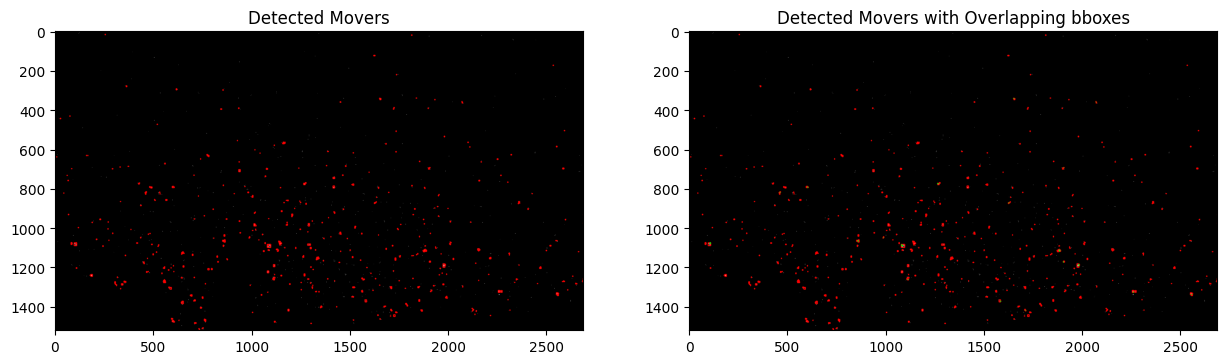

In [13]:
mask_rgb_iou = mask_rgb.copy()

# only compare unique cases
idx_1, idx_2 = np.triu_indices(len(bboxes), k=1)

for i in range(len(idx_1)):
    b1 = bboxes[idx_1[i]].tolist()
    b2 = bboxes[idx_2[i]].tolist()
    iou = compute_iou(b1, b2)
    if iou > 0:
        # print(idx, np.round(iou,2))

        # draw intersection
        x1, y1, x2, y2 = get_inter_area(b1, b2)
        cv2.rectangle(mask_rgb_iou, (x1,y1), (x2,y2), (0,255,0), 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask_rgb)
ax[0].set_title('Detected Movers')
ax[1].imshow(mask_rgb_iou)
ax[1].set_title('Detected Movers with Overlapping bboxes');

In [14]:
def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be sorted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area 
                    [[x1,y1,x2,y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained 
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [28]:
%timeit nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)

6.09 µs ± 75.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
def non_max_suppression_2(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    NOTE: Eventhough we only go through 2 loops here, this way is more complicated and slower!
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == np.array([True, True, False, False])):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
            # if no overlap check IOU threshold
            else:
                # Calculate the IoU between the two boxes
                intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                            max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
                union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                        (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
                iou = intersection / union

                # Remove boxes with IoU greater than the threshold
                # ensure that we don't remove larger boxes by checking (j > i)
                if (iou > threshold) and (j > i):
                    try:
                        keep.remove(j)
                    except ValueError:
                        continue
    return boxes[keep]

In [30]:
%timeit nms_bboxes = non_max_suppression_2(bboxes, scores, threshold=0.1)

9.14 µs ± 57.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [18]:
nms_bboxes = non_max_suppression_2(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(479, 476)

In [19]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

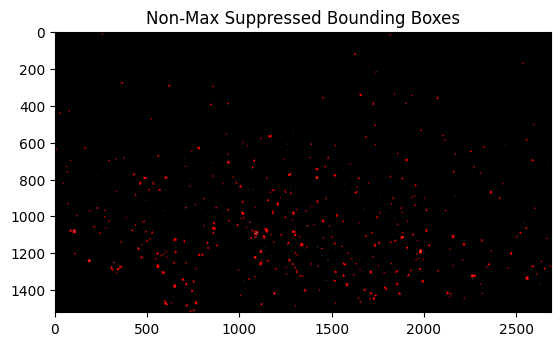

In [20]:
plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");

In [21]:
def get_detections(frame1, frame2, bbox_thresh=400, nms_thresh=1e-3, mask_kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get image mask for moving pixels
    mask = get_mask(frame1, frame2, mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(mask, bbox_thresh)

    # separate bboxes and scores
    if len(detections) > 0:
        bboxes = detections[:, :4]
        scores = detections[:, -1]

        # perform Non-Maximal Supression on initial detections
        return non_max_suppression(bboxes, scores, nms_thresh)
    return []

In [290]:
from PIL import Image


def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)
        
def draw_tracks(frame, tracks):
    for det in tracks:
        x1, y1, x2, y2, _ = det
        cv2.rectangle(
            frame,
            (int(x1),int(y1)), 
            (int(x2),int(y2)), 
            (0,255,0), 3
        )


def create_gif_from_images(save_path : str, image_path : str, ext : str) -> None:
    ''' creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    '''
    ext = ext.replace('.', '')
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=50, loop=0)

In [59]:
import shutil

image_paths = sorted(glob(f"{images_dir}/*.jpg"), key=lambda x:float(re.findall(r"(\d+)",x)[0]))

output_directory = images_dir / "output"
if output_directory.exists():
    shutil.rmtree(str(output_directory))
output_directory.mkdir(parents=True, exist_ok=True)

In [60]:
for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
                                cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=2,
                                nms_thresh=1e-4)


    # draw bounding boxes on frame
    draw_bboxes(frame2_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame2_bgr)
    plt.axis('off')
    fig.savefig(f"{output_directory}/frame_{idx}.png")
    plt.close()

In [61]:
create_gif_from_images('frame_differencing_intro.gif', str(output_directory), '.png')

## Try using IOU tracker

In [222]:
from dataclasses import dataclass

@dataclass
class BoundingBox:
    x_min: int
    y_min: int
    x_max: int
    y_max: int
    
    @classmethod
    def from_numpy(cls, array: np.array) -> "BoundingBox":
        return cls(
            x_min=int(array[0]),
            y_min=int(array[1]),
            x_max=int(array[2]),
            y_max=int(array[3])
        )
    
    def __hash__(self):
        return hash(f"{self.x_min},{self.y_min},{self.x_max},{self.y_max}")
    
    def __str__(self) -> str:
        return f"BBox [[{self.x_min}, {self.y_min}], [{self.x_max}, {self.y_max}]]"

In [23]:
images_dir = Path('../data/images/dim-meteorite-full-res')

first_image = images_dir / "179.png"
second_image = images_dir / "180.png"
third_image = images_dir / "181.png"

In [25]:
frame1_bgr = cv2.imread(str(first_image))
frame2_bgr = cv2.imread(str(second_image))
frame3_bgr = cv2.imread(str(third_image))

In [26]:
# get detections
detections = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
                            cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                            bbox_thresh=2,
                            nms_thresh=1e-4)

In [96]:
detections

array([[1078, 1084, 1096, 1100],
       [  97, 1076,  110, 1091],
       [1971, 1183, 1981, 1201],
       ...,
       [ 273, 1062,  274, 1065],
       [  44,  822,   45,  825],
       [ 732, 1517,  735, 1518]])

In [158]:
from sortedcontainers import SortedKeyList

a = SortedKeyList([(9,1), (1,3), (10, 4), (3, 5)], key=lambda x: x[0])

In [159]:
a

SortedKeyList([(1, 3), (3, 5), (9, 1), (10, 4)], key=<function <lambda> at 0x13f998b80>)

In [161]:
a[:a.bisect_key_right(3)]

[(1, 3), (3, 5)]

In [194]:
from dataclasses import dataclass, field


@dataclass
class IOUTracker:
    iou_threshold: float = 0.1
    sigma_low: float = 0.1
    sigma_high: float = 0.1
    min_track_length: int = 10
    tracks: list = field(default_factory=list, init=False)
    
    @staticmethod
    def compute_iou(box1: BoundingBox, box2: BoundingBox) -> float:
        x11, y11, x21, y21 = box1.x_min, box1.y_min, box1.x_max, box1.y_max
        x12, y12, x22, y22 = box2.x_min, box2.y_min, box2.x_max, box2.y_max
    
        # get box points of intersection
        xi1 = max(x11, x12) # top left
        yi1 = max(y11, y12)
        xi2 = min(x21, x22) # bottom right
        yi2 = min(y21, y22)
    
        # compute intersectional area
        inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
        if inter_area == 0:
            return inter_area
    
        # compute box areas
        box1_area = (x21 - x11 + 1) * (y21 - y11 + 1)
        box2_area = (x22 - x12 + 1) * (y22 - y12 + 1)
    
        # return iou
        return inter_area / (box1_area + box2_area - inter_area)
    
    def track(
            self, 
            frame_1_bboxes: list[BoundingBox],
            frame_2_bboxes: list[BoundingBox],
            sigma_iou: float = 0.1
    ) -> list:
        tracks = []
        
        # print(f"First frame has {len(frame_1_bboxes)} bboxes")
        # print(f"Second frame has {len(frame_2_bboxes)} bboxes")
    
        sorted_by_x_min_frame_2_bboxes = SortedKeyList(frame_2_bboxes, key=lambda x: x.x_min)
        sorted_by_y_min_frame_2_bboxes = SortedKeyList(frame_2_bboxes, key=lambda x: x.y_min)
        sorted_by_x_max_frame_2_bboxes = SortedKeyList(frame_2_bboxes, key=lambda x: x.x_max)
        sorted_by_y_max_frame_2_bboxes = SortedKeyList(frame_2_bboxes, key=lambda x: x.y_max)
        
        for bbox_1 in frame_1_bboxes:
            best_match_score = 0
            best_match_bbox = None
            
            # print(f"Finding matches for {bbox_1}")
            
            # only consider bboxes that have intersection
            bboxes_with_proper_x_min =  sorted_by_x_min_frame_2_bboxes[
                      :sorted_by_x_min_frame_2_bboxes.bisect_key_right(bbox_1.x_max)]
            bboxes_with_proper_x_max =  sorted_by_x_max_frame_2_bboxes[
                      sorted_by_x_max_frame_2_bboxes.bisect_key_left(bbox_1.x_min):]
            bboxes_with_proper_y_min =  sorted_by_y_min_frame_2_bboxes[
                      :sorted_by_y_min_frame_2_bboxes.bisect_key_right(bbox_1.y_max)]
            bboxes_with_proper_y_max =  sorted_by_y_max_frame_2_bboxes[
                      sorted_by_y_max_frame_2_bboxes.bisect_key_left(bbox_1.y_min):]
            
            # print(f"There are {len(bboxes_with_proper_x_min)} bboxes with proper x-min.")
            # print(f"There are {len(bboxes_with_proper_x_max)} bboxes with proper x-max.")
            # print(f"There are {len(bboxes_with_proper_y_min)} bboxes with proper y-min.")
            # print(f"There are {len(bboxes_with_proper_y_max)} bboxes with proper y-max.")
            
            matching_bboxes = set(bboxes_with_proper_x_min).intersection(bboxes_with_proper_x_max)
            matching_bboxes = matching_bboxes.intersection(bboxes_with_proper_y_min)
            matching_bboxes = matching_bboxes.intersection(bboxes_with_proper_y_max)
            
            # print(f"There are {len(matching_bboxes)} bboxes that fulfills all the criteria")
            
            for bbox_2 in matching_bboxes:
                iou_score = self.compute_iou(bbox_1, bbox_2)
                if iou_score > best_match_score:
                    best_match_bbox = bbox_2
                    best_match_score = iou_score
            
            if best_match_bbox is not None and best_match_score >= sigma_iou:
                tracks.append(best_match_bbox)
        return tracks

In [185]:
detections_1 = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
                            cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                            bbox_thresh=2,
                            nms_thresh=1e-4)
detections_2 = get_detections(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                            cv2.cvtColor(frame3_bgr, cv2.COLOR_BGR2GRAY), 
                            bbox_thresh=2,
                            nms_thresh=1e-4)

In [187]:
detections_1_bboxes = [BoundingBox.from_numpy(bbox) for bbox in detections_1]
detections_2_bboxes = [BoundingBox.from_numpy(bbox) for bbox in detections_2]

In [192]:
tracker = IOUTracker(iou_threshold=0.2)
tracker.track(detections_1_bboxes, detections_2_bboxes)

First frame has 468 bboxes
Second frame has 463 bboxes
Finding matches for BBox [[1063, 1082], [1095, 1115]]
There are 204 bboxes with proper x-min.
There are 269 bboxes with proper x-max.
There are 269 bboxes with proper y-min.
There are 229 bboxes with proper y-max.
There are 2 bboxes that fulfills all the criteria
Finding matches for BBox [[97, 1076], [110, 1091]]
There are 11 bboxes with proper x-min.
There are 453 bboxes with proper x-max.
There are 248 bboxes with proper y-min.
There are 233 bboxes with proper y-max.
There are 0 bboxes that fulfills all the criteria
Finding matches for BBox [[1971, 1183], [1981, 1201]]
There are 377 bboxes with proper x-min.
There are 88 bboxes with proper x-max.
There are 313 bboxes with proper y-min.
There are 156 bboxes with proper y-max.
There are 0 bboxes that fulfills all the criteria
Finding matches for BBox [[1283, 1082], [1298, 1089]]
There are 238 bboxes with proper x-min.
There are 228 bboxes with proper x-max.
There are 248 bboxes wit

[BoundingBox(x_min=1069, y_min=1087, x_max=1094, y_max=1102)]

In [196]:
tracker = IOUTracker(iou_threshold=0.2)
%timeit tracker.track(detections_1_bboxes, detections_2_bboxes)

315 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@dataclass
class FrameRegions:
    frame_resolution: tuple[int, int]
    region_resolution: int
    _regions: np.array
    
    def _generate_regions(self) -> None:
        frame_width, frame_height = self.frame_resolution
        
        x_regions_number = frame_width // self.region_resolution
        if frame_width % self.region_resolution != 0:
            x_regions_number += 1
            
        y_regions_number = frame_height // self.region_resolution
        if frame_height % self.region_resolution != 0:
            y_regions_number += 1
            
        self._regions = np.zeros((x_regions_number, y_regions_number, 4), dtype=np.uint8)
        
        for x_region in range(x_regions_number):
            for y_region in range(y_regions_number):
                x_min = x_region * self.region_resolution
                x_max = x_min + self.region_resolution
                if x_max >= self.frame_resolution[0]:
                    x_max = self.frame_resolution[0] - 1
            
                y_min = y_region * self.region_resolution
                y_max = y_min + self.region_resolution
                if y_max >= self.frame_resolution[1]:
                    y_max = self.frame_resolution[1] - 1
                    
                self._regions[x_region][y_region][0] = x_min
                self._regions[x_region][y_region][1] = y_min
                self._regions[x_region][y_region][2] = x_max
                self._regions[x_region][y_region][3] = y_max
        
    def get_regions_of_bbox(self, bbox: BoundingBox) -> list[BoundingBox]:
        x_region_min, x_region_max, y_region_min, y_region_max = 0, 0, 0, 0
        
        for x_region_index in range(len(self._regions)):
            for y_region_index in range(len(self._regions[x_region_index])):
                if bbox.x_min >= self._regions[x_region_index][y_region_index][0]:
                    x_region_min = x_region_index
                    
                if bbox.y_min >= self._regions[x_region_index][y_region_index][1]:
                    y_region_min = y_region_index
                
                if bbox.x_max <= self._regions[x_region_index][y_region_index][2]:
                    x_region_max = x_region_index
                
                if bbox.y_max <= self._regions[x_region_index][y_region_index][3]:
                    y_region_max = y_region_index
        
        

In [66]:
def iou_tracker(frame_1_bboxes, frame_2_bboxes, sigma_iou=0.1):
    tracks = []
    
    for bbox_1 in frame_1_bboxes:
        
        best_match_score = 0
        best_match_bbox = None
        best_match_index = 0
        for i, bbox_2 in enumerate(frame_2_bboxes):
            iou_score = compute_iou(bbox_1, bbox_2)
            if iou_score > best_match_score:
                best_match_bbox = bbox_2
                best_match_score = iou_score
                best_match_index = i
        
        if best_match_bbox is not None and best_match_score >= sigma_iou:
            tracks.append(best_match_bbox)
            frame_2_bboxes = np.delete(frame_2_bboxes, best_match_index, axis=0)
    return tracks

In [85]:
def track_iou(dets, sigma_l, sigma_h, sigma_iou, t_min):
    """
    Simple IOU based tracker.
    See "High-Speed Tracking-by-Detection Without Using Image Information by E. Bochinski, V. Eiselein, T. Sikora" for
    more information.

    Args:
         detections (list): list of detections per frame, usually generated by util.load_mot
         sigma_l (float): low detection threshold.
         sigma_h (float): high detection threshold.
         sigma_iou (float): IOU threshold.
         t_min (float): minimum track length in frames.

    Returns:
        list: list of tracks.
    """

    tracks_active = []
    tracks_finished = []

    for frame_num, detections_frame in enumerate(detections, start=1):
        # apply low threshold to detections
        # dets = [det for det in detections_frame if det['score'] >= sigma_l]

        updated_tracks = []
        for track in tracks_active:
            if len(dets) > 0:
                best_match_score = 0
                best_match_index = -1
                best_match_det = None
                for i, detection in enumerate(dets):
                    iou_score = compute_iou(track['bboxes'][-1], detection['bbox'])
                    if iou_score > best_match_score:
                        best_match_score = iou_score
                        best_match_det = detection
                        best_match_index = i
                    
                
                if best_match_det is not None and best_match_score >= sigma_iou:
                    track['bboxes'].append(best_match_det['bbox'])
                    track['max_score'] = max(track['max_score'], best_match_det['score'])

                    updated_tracks.append(track)

                    # remove from best matching detection from detections
                    dets = np.delete(dets, best_match_index)
                    

            # if track was not updated
            if len(updated_tracks) == 0 or track is not updated_tracks[-1]:
                # finish track when the conditions are met
                if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min:
                    tracks_finished.append(track)

        # create new tracks
        new_tracks = [{'bboxes': [det['bbox']], 'max_score': det['score'], 'start_frame': frame_num} for det in dets]
        tracks_active = updated_tracks + new_tracks

    # finish all remaining active tracks
    tracks_finished += [track for track in tracks_active
                        if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min]

    return tracks_finished

In [94]:
len(detections_1)

469

In [197]:
iou_tracker(detections_1, detections_2, sigma_iou=0.2)

[array([1069, 1087, 1094, 1102])]

In [198]:
%timeit iou_tracker(detections_1, detections_2, sigma_iou=0.2)

410 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [229]:
def detections_to_numpy_array(detections: list[tuple]) -> np.array:
    tracks = np.zeros((len(detections), 5), dtype=np.float32)
    for i, detection in enumerate(detections):
        tracks[i][0] = detection[0]
        tracks[i][1] = detection[1]
        tracks[i][2] = detection[2]
        tracks[i][3] = detection[3]
        tracks[i][4] = (detection[2] - detection[0]) * (detection[3] - detection[1])
    return tracks

In [221]:
from ioutrack import Sort

def track_tracks_with_sort_tracker(detections: list[tuple]) -> list[BoundingBox]:
    tracker = Sort(max_age=5, min_hits=5)
    
    detections_numpy = detections_to_numpy_array(detections)
    
    for i in range(len(detections_numpy - 1)):
        tracker.update(detections_numpy[i])
        
    tracks = tracker.update(detections_numpy[len(detections_numpy) - 1])
        
    result = []
    for bbox in tracks:
        result.append(
            BoundingBox.from_numpy(bbox)
        )
    return result

In [209]:
def get_tracks(tracker, frame_1_bboxes, frame_2_bboxes):
    tracker.update(frame_1_bboxes)
    tracks = tracker.update(frame_2_bboxes)
    
    result = []
    for bbox in tracks:
        result.append(
            BoundingBox.from_numpy(bbox)
        )
    return result

In [88]:
detection_dict_1 = [{
    'bbox': det,
    'score': 0.2,
} for det in detections_1]

detection_dict_2 = [{
    'bbox': det,
    'score': 0.2,
} for det in detections_2]

tracks = track_iou(
    detection_dict_1 + detection_dict_2,
    sigma_l=0.01, sigma_h=1, sigma_iou=0.2, t_min=1)

In [42]:
draw_bboxes(frame2_bgr, tracks)

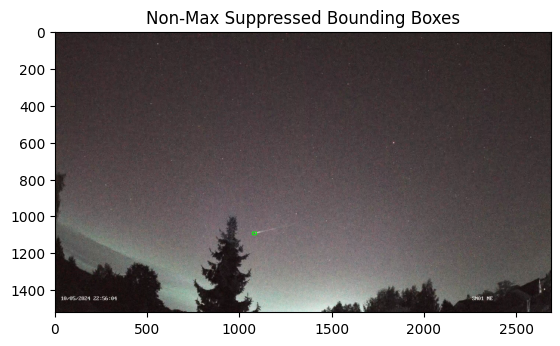

In [44]:
plt.imshow(frame2_bgr)
plt.title("Non-Max Suppressed Bounding Boxes");

In [59]:
import shutil

def save_tracks_as_images(images_directory: Path, images_extension: str) -> None:
    image_paths = sorted(glob(f"{images_directory}/*.{images_extension}"),
                         key=lambda x:float(re.findall(r"(\d+)",x)[0]))

    output_directory = images_directory / "output"
    if output_directory.exists():
        shutil.rmtree(str(output_directory))
    output_directory.mkdir(parents=True, exist_ok=True)
    
    idx = 2
    frame1_bgr = cv2.imread(image_paths[idx - 2])
    frame2_bgr = cv2.imread(image_paths[idx - 1])
    
    detections_1 = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
                                cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=2,
                                nms_thresh=1e-4)
    while idx < len(image_paths):
        # read frames
        frame3_bgr = cv2.imread(image_paths[idx])
    
        # get detections
        detections_2 = get_detections(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                                    cv2.cvtColor(frame3_bgr, cv2.COLOR_BGR2GRAY), 
                                    bbox_thresh=2,
                                    nms_thresh=1e-4)
        
        tracks = iou_tracker(detections_1, detections_2, sigma_iou=0.2)
    
    
        # draw bounding boxes on frame
        draw_bboxes(frame2_bgr, tracks)
    
        # save image for GIF
        fig = plt.figure(figsize=(15, 7))
        plt.imshow(frame2_bgr)
        plt.axis('off')
        fig.savefig(f"{output_directory}/frame_{idx - 1}.png")
        plt.close()
        
        # increment index
        frame1_bgr = frame2_bgr
        frame2_bgr = frame3_bgr
        detections_1 = detections_2
        idx += 1
        

In [223]:
def draw_detections(frame, detections: list[BoundingBox]) -> None:
    for det in detections:
        cv2.rectangle(frame, (det.x_min, det.y_min), (det.x_max, det.y_max), (0,255,0), 3)

In [291]:
def draw_tracks_on_images(image_paths: list[str], output_directory: Path) -> None:
    tracker = Sort(max_age=5, min_hits=5)
    
    idx = 2
    frame1_bgr = cv2.imread(image_paths[idx - 2])
    frame2_bgr = cv2.imread(image_paths[idx - 1])
    
    detections_1 = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
                                cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=128,
                                nms_thresh=1e-3)
    detections_1_numpy = detections_to_numpy_array(detections_1)
    tracker.update(detections_1_numpy)
    
    while idx < len(image_paths):
        # read frames
        frame3_bgr = cv2.imread(image_paths[idx])
    
        # get detections
        detections_2 = get_detections(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
                                    cv2.cvtColor(frame3_bgr, cv2.COLOR_BGR2GRAY), 
                                    bbox_thresh=128,
                                    nms_thresh=1e-3)
        
        # print(f"Between frame {idx} and frame {idx - 1} - {len(detections_2)} detections were found!")
    
        detections_2_numpy = detections_to_numpy_array(detections_2)
        tracks = tracker.update(detections_2_numpy)  
        
        # print(f"On frame {idx}: {len(tracks)} tracks were found!")
        
        # draw bounding boxes on frame
        draw_tracks(frame2_bgr, tracks)

        # save image for GIF
        fig = plt.figure(figsize=(15, 7))
        plt.imshow(frame2_bgr)
        plt.axis('off')
        fig.savefig(f"{output_directory}/frame_{idx - 1}.png")
        plt.close()
        
        # increment index
        frame1_bgr = frame2_bgr
        frame2_bgr = frame3_bgr
        detections_1 = detections_2
        idx += 1

In [217]:
import shutil

def get_image_paths(images_dir: Path, image_extension: str) -> list[str]:
    image_paths = sorted(glob(f"{images_dir}/*.{image_extension}"), 
                         key=lambda x:float(re.findall(r"(\d+)",x)[0]))
    return image_paths

In [219]:
image_paths = get_image_paths(images_dir, "png")

In [292]:
output_dir = images_dir / "output"

output_dir.mkdir(parents=True, exist_ok=True)

draw_tracks_on_images(image_paths, output_directory=output_dir)

In [293]:
create_gif_from_images('frame_differencing_with_sort_tracking.gif', str(output_dir), '.png')

(-0.5, 2687.5, 1519.5, -0.5)

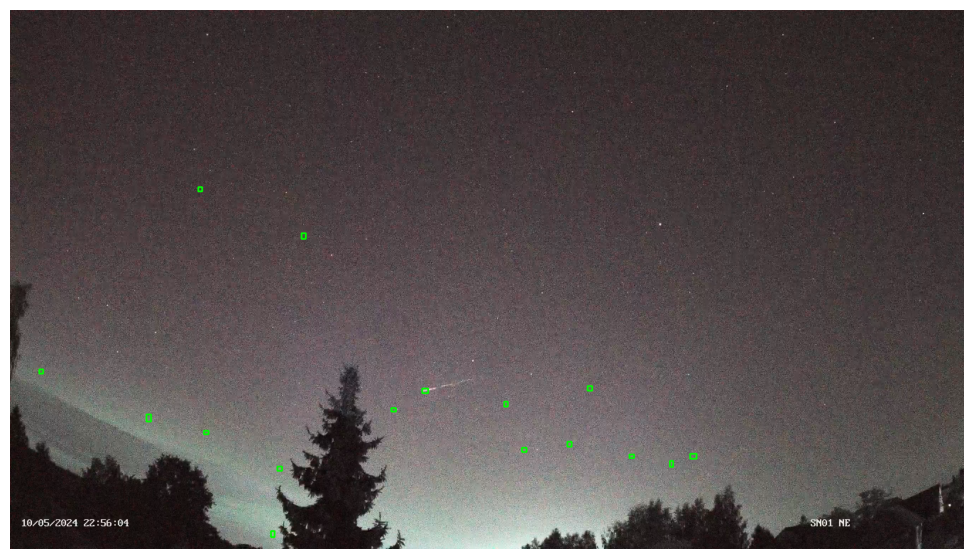

In [277]:
frame1_bgr = cv2.imread(image_paths[168])
frame2_bgr = cv2.imread(image_paths[169])

detections = get_detections(
    cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
    cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
    bbox_thresh=128,
    nms_thresh=1e-3,
    mask_kernel=np.array((16,16), dtype=np.uint8)
)

draw_bboxes(frame2_bgr, detections)

# save image for GIF
fig = plt.figure(figsize=(15, 7))
plt.imshow(frame2_bgr)
plt.axis('off')

In [258]:
len(detections)

59

In [279]:
%timeit detections = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), bbox_thresh=128, nms_thresh=1e-3, mask_kernel=np.array((9,9), dtype=np.uint8))

17.9 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [295]:
from pstats import Stats, SortKey
from cProfile import Profile

frame1_bgr = cv2.imread(image_paths[10])
frame2_bgr = cv2.imread(image_paths[11])

with Profile() as profile:
    get_detections(
        cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY), 
        cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY), 
        bbox_thresh=128,
        nms_thresh=1e-3,
        mask_kernel=np.array((16,16), dtype=np.uint8))
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

         17652560 function calls (17652558 primitive calls) in 12.156 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  3872535    0.885    0.000    0.885    0.000 {built-in method numpy.array}
  2708131    0.421    0.000    0.421    0.000 {built-in method builtins.max}
  1936267    0.194    0.000    0.194    0.000 {method 'items' of 'dict' objects}
  1936266    1.030    0.000    2.495    0.000 fromnumeric.py:71(_wrapreduction)
  1936266    0.662    0.000    3.157    0.000 fromnumeric.py:2421(all)
  1936266    0.111    0.000    0.111    0.000 fromnumeric.py:2416(_all_dispatcher)
  1936266    1.271    0.000    1.271    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1354065    0.201    0.000    0.201    0.000 {built-in method builtins.min}
    31047    0.009    0.000    0.009    0.000 {boundingRect}
     2507    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
     1396    0.000    0.000    0.000    0.000